<a href="https://colab.research.google.com/github/saraswatnitin/CausalInferenceDiscoverywithML/blob/main/8_Assumptions_working_with_Causal_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assumptions
In this section we focus on the assumptions we need to meet when working with causal inference. This is important as causal inference relies heavily on these assumptions and not meeting them might lead to biased results.
We discuss positivity and exchangeability assumptions.
Next, we discuss other assumptions. Finally we focus on unobserved variables and discuss them from yet another angle.

In [2]:
!pip install dowhy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.5
    Uninstalling Cython-3.0.5:
      Successfully uninstalled Cython-3.0.5


In [3]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import GradientBoostingRegressor

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [4]:

dowhy.__version__

'0.10.1'

In [5]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

## Not Enough Data - The Experiment

### Graph

In [6]:

# Construct the graph (the graph is constant for all iterations)
nodes = ['S', 'Q', 'X', 'Y', 'P']
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

### Experiment

In [8]:
!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 22.7 MB/s eta 0:00:00


In [9]:

# Define the true effect
TRUE_EFFECT = .7

# Define experiment params
sample_sizes = [30, 100, 1000, 10000]
noise_coefs = [.1, .2, .3, .4, .5, .6, .7, .8]
n_samples = 20

# Record the results
results = []

# Run the experiment
for sample_size in tqdm(sample_sizes):
    for noise_coef in noise_coefs:
        for i in range(n_samples):

            # Generate the data
            S = np.random.random(sample_size)
            Q = 0.2*S + noise_coef*np.random.random(sample_size)
            X = 0.14*Q + noise_coef*np.random.random(sample_size)
            Y = TRUE_EFFECT*X + 0.11*Q + 0.32*S + noise_coef*np.random.random(sample_size)
            P = 0.43*X + 0.21*Y + noise_coef*np.random.random(sample_size)

            # Encode as a pandas df
            df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

            # Instantiate the CausalModel
            model = CausalModel(
                data=df,
                treatment='X',
                outcome='Y',
                graph=gml_string
            )

            # Get the estimand
            estimand = model.identify_effect()

            # Get estimate (DML)
            estimate_dml = model.estimate_effect(
                identified_estimand=estimand,
                method_name='backdoor.econml.dml.DML',
                method_params={
                    'init_params': {
                        'model_y': GradientBoostingRegressor(),
                        'model_t': GradientBoostingRegressor(),
                        'model_final': LassoCV(fit_intercept=False),
                    },
                    'fit_params': {}}
            )

            # Get estimate (Linear Regression)
            estimate_lr = model.estimate_effect(
                identified_estimand=estimand,
                method_name='backdoor.linear_regression')

            results.append(
                {
                    'sample_size': sample_size,
                    'noise_coef': noise_coef,
                    'estimate_dml': estimate_dml.value,
                    'estimate_lr': estimate_lr.value,
                    'error_dml': estimate_dml.value - TRUE_EFFECT,
                    'error_lr': estimate_lr.value - TRUE_EFFECT
                }
            )

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_ord

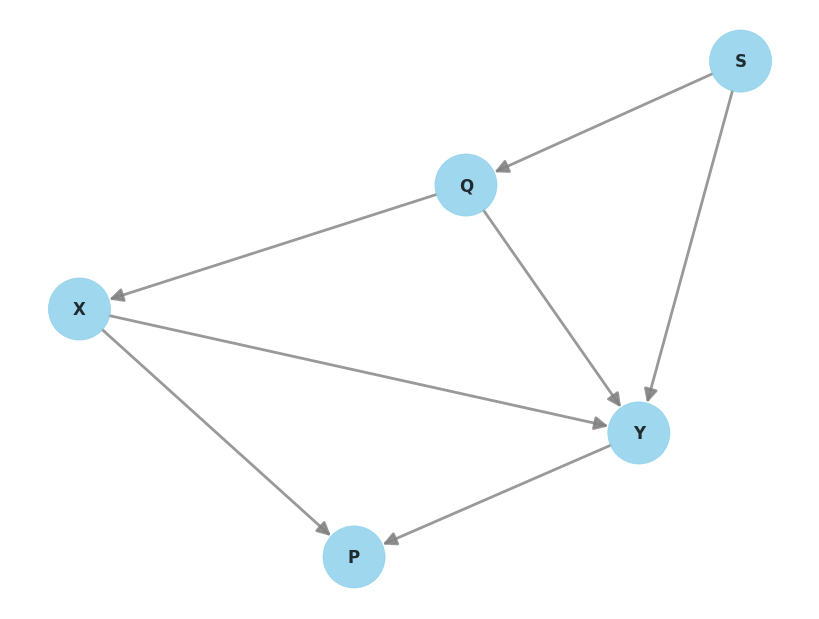

In [10]:

model.view_model()

In [11]:

results_df = pd.DataFrame(results)

In [12]:

results_df

,sample_size,noise_coef,estimate_dml,estimate_lr,error_dml,error_lr
0,30,0.1,1.114475,0.749974,0.414475,0.049974
1,30,0.1,1.102264,1.284064,0.402264,0.584064
2,30,0.1,1.177905,1.102138,0.477905,0.402138
3,30,0.1,1.209002,1.121170,0.509002,0.421170
4,30,0.1,1.001666,0.758092,0.301666,0.058092
...,...,...,...,...,...,...
635,10000,0.8,0.681564,0.681151,-0.018436,-0.018849
636,10000,0.8,0.706883,0.705595,0.006883,0.005595
637,10000,0.8,0.703642,0.705959,0.003642,0.005959
638,10000,0.8,0.720877,0.722058,0.020877,0.022058


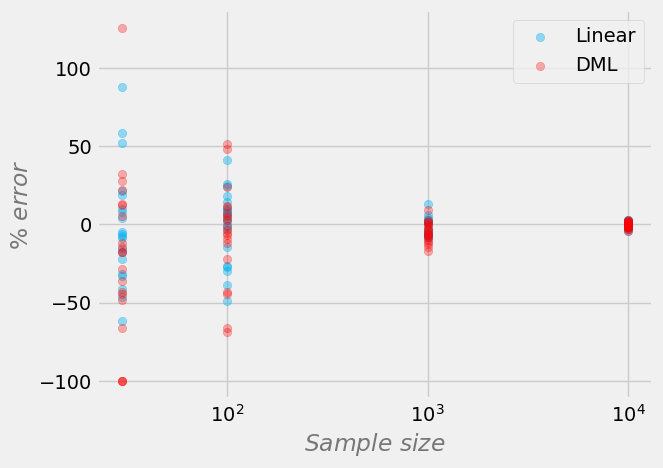

In [13]:

plt.scatter(
    results_df[results_df['noise_coef'] == .3]['sample_size'],
    (results_df[results_df['noise_coef'] == .3]['error_lr'] / TRUE_EFFECT) * 100,
    color=COLORS[0],
    alpha=.4,
    label='Linear'
)

plt.scatter(
    results_df[results_df['noise_coef'] == .3]['sample_size'],
    (results_df[results_df['noise_coef'] == .3]['error_dml'] / TRUE_EFFECT) * 100,
    color=COLORS[1],
    alpha=.3,
    label='DML'
)




plt.xscale('log')
plt.legend()
plt.xlabel('$Sample$ $size$', alpha=.5)
plt.ylabel('% $error$', alpha=.5)
plt.show()

## Positivity Assumption - An Example

In [14]:

# Helpers
def get_y(z, t):
    return z + .2 * z**2 + 10*np.sin(z) + 9*t

### Bad case

In [15]:

# Set X values
z_t0 = np.random.uniform(2, 5, 30)
z_t1 = np.random.uniform(5.2, 9, 30)

In [16]:

# Compute Y
y_t0 = get_y(z_t0, 0)
y_t1 = get_y(z_t1, 1)

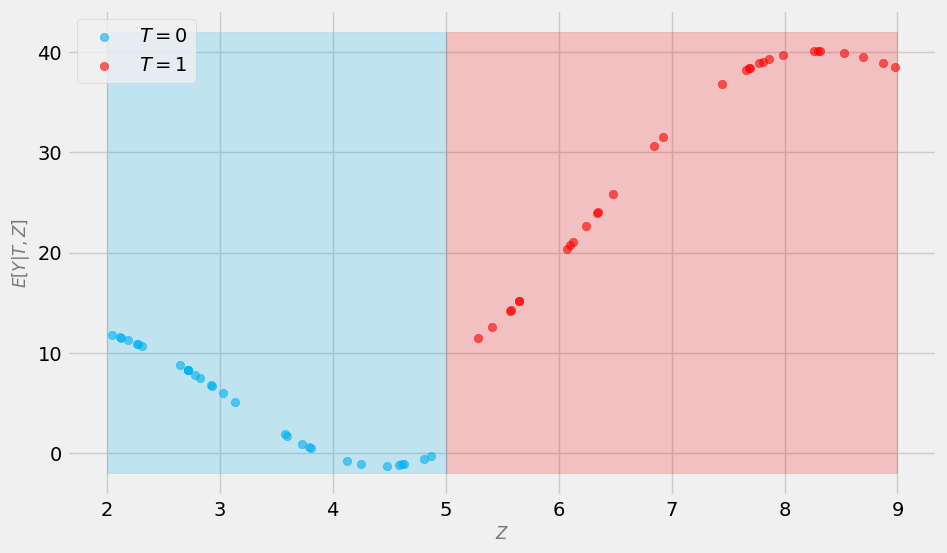

In [17]:

plt.figure(figsize=(10, 6))

plt.fill_betweenx([-2, 42], 5, 9, color=COLORS[1], alpha=.2)
plt.fill_betweenx([-2, 42], 2, 5, color=COLORS[0], alpha=.2)

plt.scatter(z_t0, y_t0, color=COLORS[0], label='$T=0$', alpha=.6)
plt.scatter(z_t1, y_t1, color=COLORS[1], label='$T=1$', alpha=.6)

plt.xlabel('$Z$', alpha=.5, fontsize=12)
plt.ylabel('$E[Y|T, Z]$', alpha=.5, fontsize=12)

plt.legend()
plt.show()

### Good case

In [18]:

# Set X values
z_t0 = np.random.uniform(2, 9, 30)
z_t1 = np.random.uniform(2, 9, 30)

# Compute Y
y_t0 = get_y(z_t0, 0)
y_t1 = get_y(z_t1, 1)

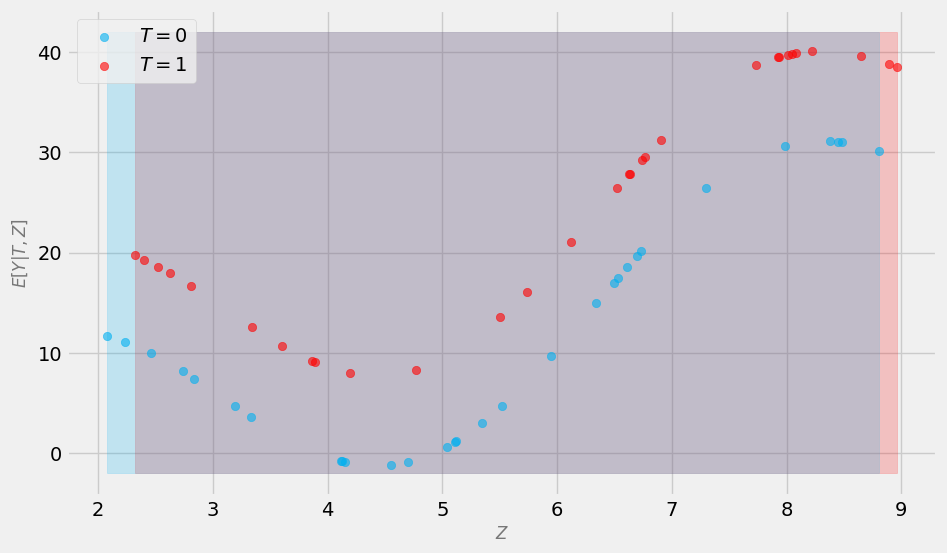

In [19]:

plt.figure(figsize=(10, 6))

plt.fill_betweenx([-2, 42], min(z_t1), max(z_t1), color=COLORS[1], alpha=.2)
plt.fill_betweenx([-2, 42], min(z_t0), max(z_t0), color=COLORS[0], alpha=.2)

plt.scatter(z_t0, y_t0, color=COLORS[0], label='$T=0$', alpha=.6)
plt.scatter(z_t1, y_t1, color=COLORS[1], label='$T=1$', alpha=.6)

plt.xlabel('$Z$', alpha=.5, fontsize=12)
plt.ylabel('$E[Y|T, Z]$', alpha=.5, fontsize=12)

plt.legend()
plt.show()

## Modularity

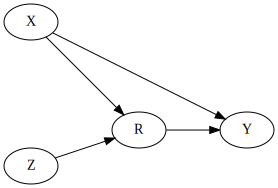

In [20]:

graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Y', 'R', 'Z']
positions = ['1,2!', '4,.5!', '2.5,.5!', '1, 0!']

edges = ['XR', 'ZR', 'RY', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_modularity')

graph

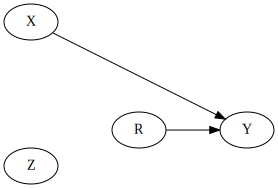

In [21]:

graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Y', 'R', 'Z']
positions = ['1,2!', '4,.5!', '2.5,.5!', '1, 0!']

edges = ['RY', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_modularity_mod')

graph

## Selection Bias: Missing Holes & Abraham Wald

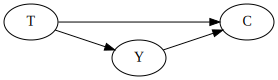

In [22]:

graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['T', 'Y', 'C']
positions = ['0,.5!', '1.5,0!', '3,.5!']

edges = ['TY', 'TC', 'YC']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_selection')

graph

In [23]:

SAMPLE_SIZE = 1000

# A hypothetical SCM
T = np.random.uniform(20, 110, SAMPLE_SIZE)
Y = T + np.random.uniform(0, 40, SAMPLE_SIZE)
C = (T + Y < 100).astype('int')

In [24]:

df = pd.DataFrame(np.stack([T, Y, C]).T, columns=['T', 'Y', 'C'])

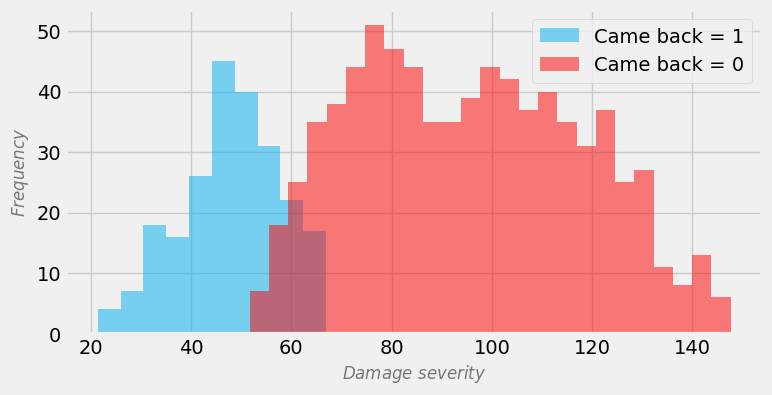

In [25]:

# Compare average damage (biased vs unbiased)
plt.figure(figsize=(8, 4))

plt.hist(df[df['C'] == 1]['Y'], label='Came back = 1', color=COLORS[0], alpha=.5)
plt.hist(df[df['C'] == 0]['Y'], label='Came back = 0', color=COLORS[1], alpha=.5, bins=25)

plt.xlabel('$Damage$ $severity$', alpha=.5, fontsize=12)
plt.ylabel('$Frequency$', alpha=.5, fontsize=12)

plt.legend()
plt.show()

## More selection bias

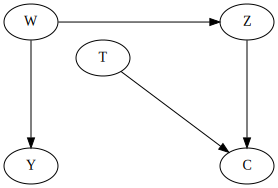

In [26]:

graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['T', 'Y', 'C', 'Z', 'W']
positions = ['1.,1.5!', '0,0!', '3,0!', '3,2!', '0,2!']

edges = ['ZC', 'TC', 'WZ', 'WY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_selection_02')

graph

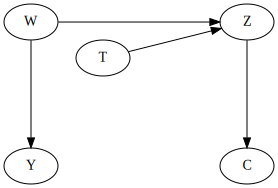

In [27]:

graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['T', 'Y', 'C', 'Z', 'W']
positions = ['1.,1.5!', '0,0!', '3,0!', '3,2!', '0,2!']

edges = ['TZ', 'ZC', 'WZ', 'WY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_08_selection_03')

graph